<a href="https://colab.research.google.com/github/stephenbeckr/randomized-algorithm-class/blob/master/Demos/demo14_MonteCarlo_and_improvements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo and variants

Discusses Monte Carlo in the context of integration:

- There are many ways to integrate functions
- Deterministic "quadrature" rules are fancy Riemann Sums, and will work *very well* if the integrand is smooth and in low dimensions. They break down when the integrand is highly oscillatory, and/or for high-dimensional integrals. Special versions targeted for oscillatory integrals is the subject of current applied math research.
- Monte Carlo integration interprets the integral as an expectation of a random variable, and draws samples to approximate the true mean with a sample mean.    For a smooth function in low dimensions, Monte Carlo integration is a bad idea because     classical quadrature rules are much, much better
- Monte Carlo is slow/inaccurate, but the inaccuracy is independent     of the dimension of the integral. So for large enough dimensions, it makes sense (while in large dimensions, making a deterministic grid is impossible since it will be too large)
- Since Monte Carlo is useful sometimes, there are many known techniques to make it better. We examine two:
  - **Quasi Monte Carlo**, which uses low-discrepancy sequences, and inherits some of the advantages and disadvantages from both Monte Carlo and grid/quadrature methods. Refs: 
    - [wikipedia low-discrepancy sequences](https://en.wikipedia.org/wiki/Low-discrepancy_sequence#Construction_of_low-discrepancy_sequences)
    - ["High-dimensional integration: The quasi-Monte Carlo way"](https://web.maths.unsw.edu.au/~josefdick/preprints/DKS2013_Acta_Num_Version.pdf) by Dick, Kuo and Sloan (Acta Numerica, 2013)
  - **Control variates** as a means of **variance reduction**. Refs: 
    - [wikipedia control variates](https://en.wikipedia.org/wiki/Control_variates)
    - There are many types of variance reduction. Other methods, not discussed here, include antithetic variates, [importance sampling](https://en.wikipedia.org/wiki/Importance_sampling) and [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling).

Stephen Becker, University of Colorado, April 2019, ipynb version Nov 2021

In [17]:
import numpy as np
from scipy.special import sici
from numpy import sinc, pi
rng=np.random.default_rng()
from numpy.linalg import norm

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["figure.figsize"] = [8,5]

## Integrate $\sin(x)/x$ from 0 to 1 (e.g. Si(1), Si is Sine Integral)

The sine integral, Si(z), is the integral of $\sin(x)/x$ from 0 to z where we define $\sin(0)/0$ to be 0 (consistent with the limit)

This integral is not known in closed form. See [Trigonometric_integral#Sine_integral](https://en.wikipedia.org/wiki/Trigonometric_integral#Sine_integral) on wikipedia.

How can we approximate it? There are specialized techniques that are faster and more accurate than what we will discuss here, but we'll treat it via the integral definition and try to numerically evaluate the integral.

In [4]:
si = sici(1)[0]
print(f"The sine integral Si(1) is {si}")

The sine integral Si(1) is 0.9460830703671831


Let's try some classical [quadrature rules](https://en.wikipedia.org/wiki/Numerical_integration) to integrate $\int_a^bf(x)\,dx$

In [15]:
f = lambda x : sinc(x/pi)
a = 0
b = 1

N = int(4e1) + 1  # simpler to have it odd (for Simpson's rule)

xgrid, h   = np.linspace(a,b,num=N,retstep=True) # spacing is h

composite_mid   = h*np.sum( f( xgrid[1:]-h/2) ) # open formula
fx  = f(xgrid)
composite_trap  = h*(np.sum(fx) - fx[0]/2 - fx[-1]/2 )
composite_simp  = h/3*(fx[0]+fx[-1]+4*np.sum(fx[1::2]) + 2*np.sum(fx[2:-1:2]))

print( si - composite_mid)
print( si - composite_trap)
print( si - composite_simp)

-7.843018420272685e-06
1.5685964777967243e-05
-3.8434844196189033e-10


Getting ready for quasi-Monte Carlo, let's visualize discrepancy of random numbers on $[0,1]$

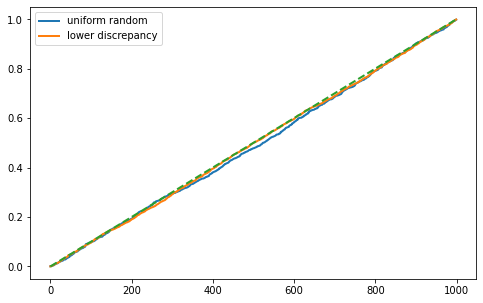

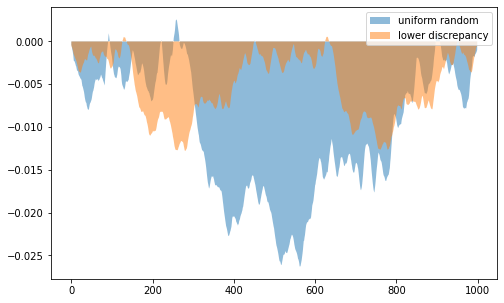

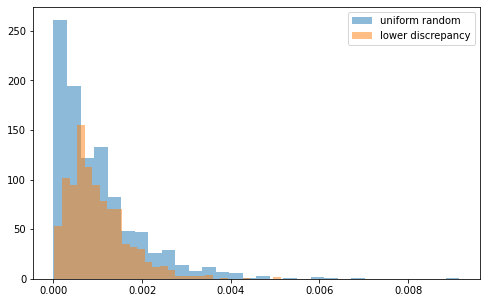

In [65]:
N   = int(1e3)

setA  = np.sort( rng.uniform(size=N) )    # uniform
setB  = np.hstack( (.5*setA[::2], .5 + .5*setA[1::2]) ) # lower discrepancy

plt.plot( setA, label='uniform random' )
plt.plot( setB, label='lower discrepancy' )
plt.plot( [0,N-1], [0,1], '--')
plt.legend()
plt.show()

# == Another way to plot it ==
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
smooth = lambda data : np.convolve(data, kernel, mode='same')

plt.fill_between( np.arange(N), 0, smooth( setA - np.linspace(0,1,num=N) ), \
         label='uniform random', alpha=0.5 )
plt.fill_between( np.arange(N), 0, smooth( setB - np.linspace(0,1,num=N) ), 
         label='lower discrepancy', alpha=0.5  )
plt.legend()
plt.show()

# == Another way to plot it ==
plt.hist( np.diff(setA), label='uniform random', alpha=0.5, bins=30 )
plt.hist( np.diff(setB), label='lower discrepancy', alpha=0.5, bins=30 )
plt.legend()
plt.show()

Now use MC and quasi-MC to evaluate the integral

In [90]:
N = int(9e2) + 1  # simpler to have it odd (for Simpson's rule)

setA  = np.sort( rng.uniform(size=N) )    # uniform
setB  = np.hstack( (.5*setA[::2], .5 + .5*setA[1::2]) ) # lower discrepancy

int_MC  = np.mean( f(setA) )  # simple!
int_QMC = np.mean( f(setB) )  # simple!
print(f"Via Monte Carlo, error is\t\t{si-int_MC:.3e}")
print(f"Via Quasi-Monte Carlo, error is\t\t{si-int_QMC:.3e}")

## and for comparison with quadrature ...

xgrid, h   = np.linspace(a,b,num=N,retstep=True) # spacing is h

composite_mid   = h*np.sum( f( xgrid[1:]-h/2) ) # open formula
fx  = f(xgrid)
composite_trap  = h*(np.sum(fx) - fx[0]/2 - fx[-1]/2 )
composite_simp  = h/3*(fx[0]+fx[-1]+4*np.sum(fx[1::2]) + 2*np.sum(fx[2:-1:2]))

print(f"Via comp. midpt rule, error is\t\t{si-composite_mid:.3e}")
print(f"Via comp. trap rule, error is\t\t{si-composite_trap:.3e}")
print(f"Via comp. simpson's rule, error is\t{si-composite_simp:.3e}")

Via Monte Carlo, error is		9.382e-04
Via Quasi-Monte Carlo, error is		2.423e-04
Via comp. midpt rule, error is		-1.549e-08
Via comp. trap rule, error is		3.098e-08
Via comp. simpson's rule, error is	-1.443e-15


#### Now add in control variates
We're trying to integrate
$$ \int_0^1 \left( f(x) = \frac{\sin(x)}{x}\right) \,dx$$
which has no closed form. But we can integrate polynomials in closed form.  Let's approximate $f$ by it's Maclaurin series,
$$ f(x) \approx g(x) = 1 - x^2/6 $$
and we can compute
$$ \nu = \int_0^1 g(x)\,dx = \frac{17}{18} $$
using basic calculus.


In [101]:
g  = lambda x : 1 - x**2/6
nu = 17/18

x = rng.uniform(size=N)
fx = f(x)  
gx = g(x)
int_MC  = np.mean( fx )

# Estimate the covariance and variance of gx
Cov = np.cov( np.vstack( (fx,gx-nu) )  )
print("Scaled covariance matrix:")
print(Cov/norm(Cov.flatten(),ord=np.Inf))
c = -Cov[0,1]/Cov[1,1]
# Or this is slightly more accurate, using that we know mean(gx) exactly:
c = -np.dot(fx-int_MC,gx-nu)/(norm(gx-nu)**2)

print(f"Using c value of {c:.5f}")
# c = -1 # this is also reasonable

int_MC_CV  = int_MC + c*( np.mean(gx) - nu )

print(f"Via Monte Carlo, error is\t\t\t{si-int_MC:.3e}")
print(f"Via Monte Carlo w/ control variates, error is\t{si-int_MC_CV:.3e}")
# Just the Taylor series alone isn't as accurage:
print(f" And approximating integral with nu, error is\t{si-nu:.3e}")

# Look at variance
print(f"Variance of MC is \t\t{np.mean( (fx - si)**2 ):.2e}")
print(f"Variance w. control variates is\t{np.mean( (fx + c*(gx-nu) - si)**2 ):.2e}")

Scaled covariance matrix:
[[0.91732862 0.95769225]
 [0.95769225 1.        ]]
Using c value of -0.95707
Via Monte Carlo, error is			1.229e-03
Via Monte Carlo w/ control variates, error is	1.790e-05
 And approximating integral with nu, error is	1.639e-03
Variance of MC is 		2.25e-03
Variance w. control variates is	3.79e-07


Plot the error as a function of number of samples

With the control variates, we don't change the $1/sqrt{n}$ decay rate, but we do improve the constant factor

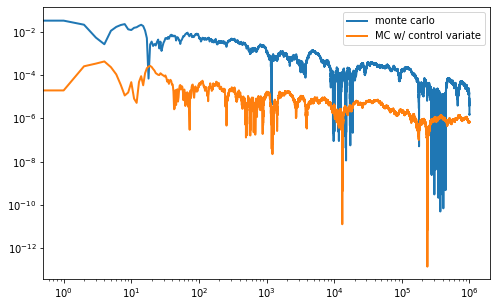

In [107]:
N   = int(1e6)
x = rng.uniform(size=N)
fx = f(x)
gx = g(x)

er = np.abs( np.cumsum(fx)/np.arange(1,N+1) - si )
plt.loglog( er , label='monte carlo' )

er = np.abs( np.cumsum(fx+c*(gx-nu))/np.arange(1,N+1) - si )
plt.loglog( er , label='MC w/ control variate' )
plt.legend()
plt.show()

### Estimate the value of $\pi$
i.e., 2D integration of an indicator function

We use the fact that the area of the unit circle  is $\pi$, and so will look at the the ratio of the area of the unit circle to that of $[-1,1]^2$.  Or equivalently, we can work in just the first quadrant.

In [108]:
n   = int(1e7)

# Note: shape 2xn is faster than nx2 when n > 1e7
X   = rng.uniform( size=(2,n) )
nrm = norm( X, ord=2, axis=0)

Y   = nrm <= 1

# Our final estimate for pi is just # 0's / total number, scaled by 4
# est = 4*np.count_nonzero(Y)/n
est = 4*np.mean(Y) # another way
print(f"Monte Carlo estimate of pi is {est:.6f}")

Monte Carlo estimate of pi is 3.141810


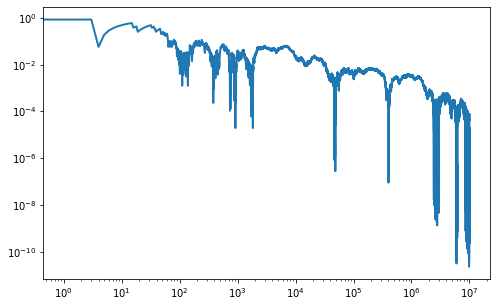

Variance is 2.70e+00


In [104]:
# Let's also look at how this converges over time
mc = np.cumsum( Y )/np.arange(1,n+1)
err = np.abs( 4*mc - np.pi )
plt.loglog( err )
plt.show()

var = np.mean( (4*Y - np.pi)**2 )
print(f"Variance is {var:.2e}")

#### Let's add a control variate

Let's add in a polyhedral approximation, consisting of the lines connecting the points $(0,1)$, $(1/\sqrt{2},1/\sqrt{2})$ and $(1,0)$.

Decomposing this into triangles, and we can figure out that it's area (in the first quadrant) is $1/\sqrt{2}$.

This control variate isn't that good, so we won't see great results unfortunately.

In [109]:
slope = 1 - np.sqrt(2)
intrcpt = 1
Za = X[0,:] <= slope*X[1,:] + intrcpt
Zb = X[1,:] <= slope*X[0,:] + intrcpt  # it's symmetric
Z  = Za & Zb
sample_mean = np.mean(Z)
true_mean   = 1/np.sqrt(2)  # to use a control variate, you need to know this
print(f"Sample mean is {sample_mean}, true mean is {true_mean}")
# ... just checking.

Sample mean is 0.7072652, true mean is 0.7071067811865475


In [110]:
# Estimate parameter "c", c = -Cov(Y,Z)/Var(Y)
# The parameter c is high (close to 1), indicating good correlation
Cov = np.cov( np.vstack( (Y,Z) )  )
print("Scaled covariance matrix:")
print(Cov/norm(Cov.flatten(),ord=np.Inf))
c = -Cov[0,1]/Cov[1,1]
print(c)

Scaled covariance matrix:
[[0.81392941 0.7329074 ]
 [0.7329074  1.        ]]
-0.7329073960457647


In [111]:
CV = Y + c*( Z - true_mean)

est = 4*np.mean(CV)
print(f"Monte Carlo w. control variate estimate of pi is {est:.6f}")

Monte Carlo w. control variate estimate of pi is 3.141346


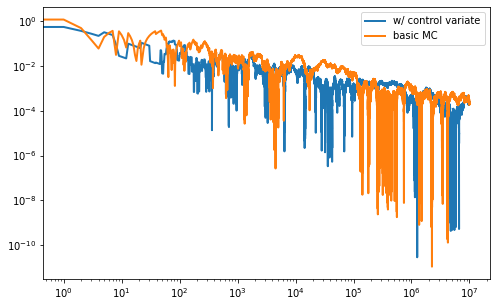

Variance is 2.70e+00
Variance (using control variate) is 9.17e-01


In [113]:
mc = np.cumsum( CV )/np.arange(1,n+1)
err = np.abs( 4*mc - np.pi )
plt.loglog( err, label='w/ control variate' )

mc = np.cumsum( Y )/np.arange(1,n+1)
err = np.abs( 4*mc - np.pi )
plt.loglog( err, label='basic MC' )
plt.legend()
plt.show()

var = np.mean( (4*Y - np.pi)**2 )
print(f"Variance is {var:.2e}")

var = np.mean( (4*CV - np.pi)**2 )
print(f"Variance (using control variate) is {var:.2e}")